# Machine Learning Engineer Nanodegree
## Supervised Learning
## Project: Finding Donors for *CharityML*

Welcome to the second project of the Machine Learning Engineer Nanodegree! In this notebook, some template code has already been provided for you, and it will be your job to implement the additional functionality necessary to successfully complete this project. Sections that begin with **'Implementation'** in the header indicate that the following block of code will require additional functionality which you must provide. Instructions will be provided for each section and the specifics of the implementation are marked in the code block with a `'TODO'` statement. Please be sure to read the instructions carefully!

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question X'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.  

>**Note:** Please specify WHICH VERSION OF PYTHON you are using when submitting this notebook. Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

Version: Python 2.7

## Getting Started

In this project, you will employ several supervised algorithms of your choice to accurately model individuals' income using data collected from the 1994 U.S. Census. You will then choose the best candidate algorithm from preliminary results and further optimize this algorithm to best model the data. Your goal with this implementation is to construct a model that accurately predicts whether an individual makes more than $50,000. This sort of task can arise in a non-profit setting, where organizations survive on donations.  Understanding an individual's income can help a non-profit better understand how large of a donation to request, or whether or not they should reach out to begin with.  While it can be difficult to determine an individual's general income bracket directly from public sources, we can (as we will see) infer this value from other publically available features. 

The dataset for this project originates from the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/Census+Income). The datset was donated by Ron Kohavi and Barry Becker, after being published in the article _"Scaling Up the Accuracy of Naive-Bayes Classifiers: A Decision-Tree Hybrid"_. You can find the article by Ron Kohavi [online](https://www.aaai.org/Papers/KDD/1996/KDD96-033.pdf). The data we investigate here consists of small changes to the original dataset, such as removing the `'fnlwgt'` feature and records with missing or ill-formatted entries.

----
## Exploring the Data
Run the code cell below to load necessary Python libraries and load the census data. Note that the last column from this dataset, `'income'`, will be our target label (whether an individual makes more than, or at most, $50,000 annually). All other columns are features about each individual in the census database.

In [2]:
# Import libraries necessary for this project
import numpy as np
import pandas as pd
from time import time
from IPython.display import display # Allows the use of display() for DataFrames

# Import supplementary visualization code visuals.py
import visuals as vs

# Pretty display for notebooks
%matplotlib inline

# Load the Census dataset
data = pd.read_csv("census.csv")

# Success - Display the first record
display(data.head(n=1))

,age,workclass,education_level,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,Bachelors,13.0,Never-married,Adm-clerical,Not-in-family,White,Male,2174.0,0.0,40.0,United-States,<=50K


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45222 entries, 0 to 45221
Data columns (total 14 columns):
age                45222 non-null int64
workclass          45222 non-null object
education_level    45222 non-null object
education-num      45222 non-null float64
marital-status     45222 non-null object
occupation         45222 non-null object
relationship       45222 non-null object
race               45222 non-null object
sex                45222 non-null object
capital-gain       45222 non-null float64
capital-loss       45222 non-null float64
hours-per-week     45222 non-null float64
native-country     45222 non-null object
income             45222 non-null object
dtypes: float64(4), int64(1), object(9)
memory usage: 4.8+ MB


### Implementation: Data Exploration
A cursory investigation of the dataset will determine how many individuals fit into either group, and will tell us about the percentage of these individuals making more than \$50,000. In the code cell below, you will need to compute the following:
- The total number of records, `'n_records'`
- The number of individuals making more than \$50,000 annually, `'n_greater_50k'`.
- The number of individuals making at most \$50,000 annually, `'n_at_most_50k'`.
- The percentage of individuals making more than \$50,000 annually, `'greater_percent'`.

**Hint:** You may need to look at the table above to understand how the `'income'` entries are formatted. 

In [4]:
# TODO: Total number of records
n_records = data.shape[0]

# TODO: Number of records where individual's income is more than $50,000
n_greater_50k = data.loc[(data['income'] == '>50K')].shape[0]

# TODO: Number of records where individual's income is at most $50,000
n_at_most_50k = data.loc[(data['income'] == '<=50K')].shape[0]

# TODO: Percentage of individuals whose income is more than $50,000
greater_percent = (n_greater_50k / float(n_records))*100

# Print the results
print "Total number of records: {}".format(n_records)
print "Individuals making more than $50,000: {}".format(n_greater_50k)
print "Individuals making at most $50,000: {}".format(n_at_most_50k)
print "Percentage of individuals making more than $50,000: {:.2f}%".format(greater_percent)

Total number of records: 45222
Individuals making more than $50,000: 11208
Individuals making at most $50,000: 34014
Percentage of individuals making more than $50,000: 24.78%


----
## Preparing the Data
Before data can be used as input for machine learning algorithms, it often must be cleaned, formatted, and restructured — this is typically known as **preprocessing**. Fortunately, for this dataset, there are no invalid or missing entries we must deal with, however, there are some qualities about certain features that must be adjusted. This preprocessing can help tremendously with the outcome and predictive power of nearly all learning algorithms.

### Transforming Skewed Continuous Features
A dataset may sometimes contain at least one feature whose values tend to lie near a single number, but will also have a non-trivial number of vastly larger or smaller values than that single number.  Algorithms can be sensitive to such distributions of values and can underperform if the range is not properly normalized. With the census dataset two features fit this description: '`capital-gain'` and `'capital-loss'`. 

Run the code cell below to plot a histogram of these two features. Note the range of the values present and how they are distributed.

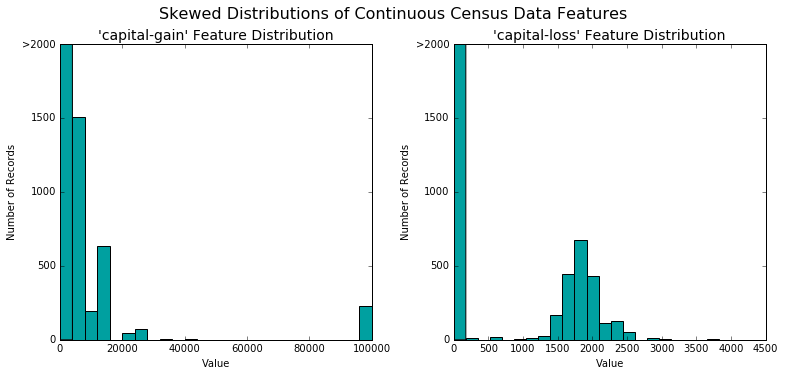

In [9]:
# Split the data into features and target label
income_raw = data['income']
features_raw = data.drop('income', axis = 1)

# Visualize skewed continuous features of original data
vs.distribution(data)

For highly-skewed feature distributions such as `'capital-gain'` and `'capital-loss'`, it is common practice to apply a <a href="https://en.wikipedia.org/wiki/Data_transformation_(statistics)">logarithmic transformation</a> on the data so that the very large and very small values do not negatively affect the performance of a learning algorithm. Using a logarithmic transformation significantly reduces the range of values caused by outliers. Care must be taken when applying this transformation however: The logarithm of `0` is undefined, so we must translate the values by a small amount above `0` to apply the the logarithm successfully.

Run the code cell below to perform a transformation on the data and visualize the results. Again, note the range of values and how they are distributed. 

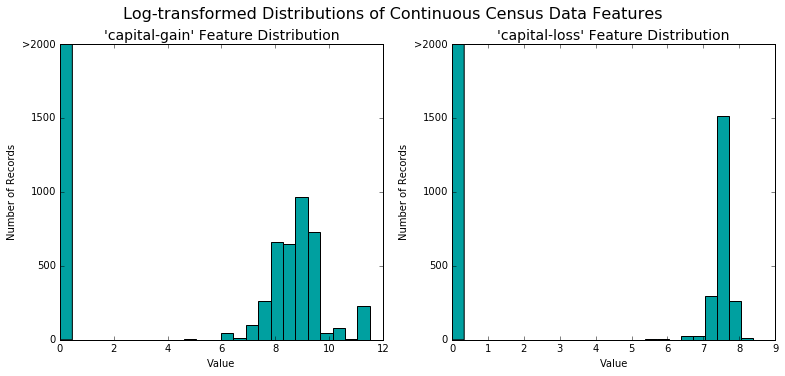

In [10]:
# Log-transform the skewed features
skewed = ['capital-gain', 'capital-loss']
features_raw[skewed] = data[skewed].apply(lambda x: np.log(x + 1))

# Visualize the new log distributions
vs.distribution(features_raw, transformed = True)

### Normalizing Numerical Features
In addition to performing transformations on features that are highly skewed, it is often good practice to perform some type of scaling on numerical features. Applying a scaling to the data does not change the shape of each feature's distribution (such as `'capital-gain'` or `'capital-loss'` above); however, normalization ensures that each feature is treated equally when applying supervised learners. Note that once scaling is applied, observing the data in its raw form will no longer have the same original meaning, as exampled below.

Run the code cell below to normalize each numerical feature. We will use [`sklearn.preprocessing.MinMaxScaler`](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html) for this.

In [11]:
# Import sklearn.preprocessing.MinMaxScaler
from sklearn.preprocessing import MinMaxScaler

# Initialize a scaler, then apply it to the features
scaler = MinMaxScaler()
numerical = ['age', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']
features_raw[numerical] = scaler.fit_transform(data[numerical])

# Show an example of a record with scaling applied
display(features_raw.head(n = 1))

,age,workclass,education_level,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country
0,0.30137,State-gov,Bachelors,0.8,Never-married,Adm-clerical,Not-in-family,White,Male,0.02174,0.0,0.397959,United-States


### Implementation: Data Preprocessing

From the table in **Exploring the Data** above, we can see there are several features for each record that are non-numeric. Typically, learning algorithms expect input to be numeric, which requires that non-numeric features (called *categorical variables*) be converted. One popular way to convert categorical variables is by using the **one-hot encoding** scheme. One-hot encoding creates a _"dummy"_ variable for each possible category of each non-numeric feature. For example, assume `someFeature` has three possible entries: `A`, `B`, or `C`. We then encode this feature into `someFeature_A`, `someFeature_B` and `someFeature_C`.

|   | someFeature |                    | someFeature_A | someFeature_B | someFeature_C |
| :-: | :-: |                            | :-: | :-: | :-: |
| 0 |  B  |  | 0 | 1 | 0 |
| 1 |  C  | ----> one-hot encode ----> | 0 | 0 | 1 |
| 2 |  A  |  | 1 | 0 | 0 |

Additionally, as with the non-numeric features, we need to convert the non-numeric target label, `'income'` to numerical values for the learning algorithm to work. Since there are only two possible categories for this label ("<=50K" and ">50K"), we can avoid using one-hot encoding and simply encode these two categories as `0` and `1`, respectively. In code cell below, you will need to implement the following:
 - Use [`pandas.get_dummies()`](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.get_dummies.html?highlight=get_dummies#pandas.get_dummies) to perform one-hot encoding on the `'features_raw'` data.
 - Convert the target label `'income_raw'` to numerical entries.
   - Set records with "<=50K" to `0` and records with ">50K" to `1`.

In [12]:
# TODO: One-hot encode the 'features_raw' data using pandas.get_dummies()
features = pd.get_dummies(features_raw)

# TODO: Encode the 'income_raw' data to numerical values
from sklearn import preprocessing  
label_encoder = preprocessing.LabelEncoder()  
income = label_encoder.fit_transform(income_raw)
# Recover labels by using inverse_transform()
# A simpler method might be pd.get_dummies(income_raw)['<=50K']

# Print the number of features after one-hot encoding
encoded = list(features.columns)
print "{} total features after one-hot encoding.".format(len(encoded))

# Uncomment the following line to see the encoded feature names
# print encoded

103 total features after one-hot encoding.


### Shuffle and Split Data
Now all _categorical variables_ have been converted into numerical features, and all numerical features have been normalized. As always, we will now split the data (both features and their labels) into training and test sets. 80% of the data will be used for training and 20% for testing.

Run the code cell below to perform this split.

In [13]:
# Import train_test_split
from sklearn.model_selection import train_test_split

# Split the 'features' and 'income' data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, income, test_size = 0.2, random_state = 0)

# Show the results of the split
print "Training set has {} samples.".format(X_train.shape[0])
print "Testing set has {} samples.".format(X_test.shape[0])

Training set has 36177 samples.
Testing set has 9045 samples.


----
## Evaluating Model Performance
In this section, we will investigate four different algorithms, and determine which is best at modeling the data. Three of these algorithms will be supervised learners of your choice, and the fourth algorithm is known as a *naive predictor*.

### Metrics and the Naive Predictor
*CharityML*, equipped with their research, knows individuals that make more than \$50,000 are most likely to donate to their charity. Because of this, *CharityML* is particularly interested in predicting who makes more than \$50,000 accurately. It would seem that using **accuracy** as a metric for evaluating a particular model's performace would be appropriate. Additionally, identifying someone that *does not* make more than \$50,000 as someone who does would be detrimental to *CharityML*, since they are looking to find individuals willing to donate. Therefore, a model's ability to precisely predict those that make more than \$50,000 is *more important* than the model's ability to **recall** those individuals. We can use **F-beta score** as a metric that considers both precision and recall:

$$ F_{\beta} = (1 + \beta^2) \cdot \frac{precision \cdot recall}{\left( \beta^2 \cdot precision \right) + recall} $$

In particular, when $\beta = 0.5$, more emphasis is placed on precision. This is called the **F$_{0.5}$ score** (or F-score for simplicity).

Looking at the distribution of classes (those who make at most \$50,000, and those who make more), it's clear most individuals do not make more than \$50,000. This can greatly affect **accuracy**, since we could simply say *"this person does not make more than \$50,000"* and generally be right, without ever looking at the data! Making such a statement would be called **naive**, since we have not considered any information to substantiate the claim. It is always important to consider the *naive prediction* for your data, to help establish a benchmark for whether a model is performing well. That been said, using that prediction would be pointless: If we predicted all people made less than \$50,000, *CharityML* would identify no one as donors. 

### Question 1 - Naive Predictor Performace
*If we chose a model that always predicted an individual made more than \$50,000, what would that model's accuracy and F-score be on this dataset?*  
**Note:** You must use the code cell below and assign your results to `'accuracy'` and `'fscore'` to be used later.

In [44]:
predictions = np.full(X_train.shape[0], label_encoder.transform(['>50K'])[0])
# Calculate some characteristics of the predictions
correct_predictions = sum(predictions == y_train)
# Adding the two binary arrays will yield 2 for true positives and 0 for true negatives
# Comparing the mismatches (when the addition yields 1) to predictions and true labels provides false positives/negatives
true_positives = sum((predictions + y_train) == 2)
false_positives = sum((predictions + y_train) == predictions)
false_negatives = sum((predictions + y_train) == y_train)

precision = true_positives / float((true_positives+false_positives))
recall = true_positives / float((true_positives+false_negatives))

# TODO: Calculate accuracy
# Compare predictions to y_train, sum all instances where the two are identical
accuracy = sum(predictions == y_train)/float(len(predictions))

# TODO: Calculate F-score using the formula above for beta = 0.5
beta = 0.5
fscore =(1+beta**2)*(precision*recall)/((beta**2 * precision) + recall)

# Print the results 
print "Naive Predictor \nAccuracy score: {:.4f}\nF-score: {:.4f}".format(accuracy, fscore)

Naive Predictor 
Accuracy score: 0.2489
F-score: 0.2929


###  Supervised Learning Models
**The following supervised learning models are currently available in** [`scikit-learn`](http://scikit-learn.org/stable/supervised_learning.html) **that you may choose from:**
- Gaussian Naive Bayes (GaussianNB)
    - Works well with large feature spaces. 
    - Fits data to a Gaussian distribution. 
    - Remember distribution from above, not exactly Gaussian due to large number at extreme left tail. 
    - Also doesn't really make sense to fit a Gaussian model to features which are one-hot encoded.
- Decision Trees
    - Quite fast.
    - Prone to overfitting. 
    - Handle mixed features (categorical and numerical) well. 
    - Ignores redundant variables. 
    - Optimizes for information gain. 
- Ensemble Methods (Bagging, AdaBoost, Random Forest, Gradient Boosting)
    - Reduce tendency to overfit.
    - Same benefits as decision trees.
- K-Nearest Neighbors (KNeighbors)
    - Large variance in performance results based on tuning parameters. 
- Stochastic Gradient Descent Classifier (SGDC)
    - Flexible approach, can use any convex loss function. 
- Support Vector Machines (SVM)
    - Doesn't perform exceptionally well with noisy datasets. 
    - Slow to train on large datasets. 
- Logistic Regression
    - Simple, easy to train approach. 

### Question 2 - Model Application
List three of the supervised learning models above that are appropriate for this problem that you will test on the census data. For each model chosen
- *Describe one real-world application in industry where the model can be applied.* (You may need to do research for this — give references!)
- *What are the strengths of the model; when does it perform well?*
- *What are the weaknesses of the model; when does it perform poorly?*
- *What makes this model a good candidate for the problem, given what you know about the data?*

**Answer: **

##### Support Vector Machines (SVM)
- *Describe one real-world application in industry where the model can be applied.* (You may need to do research for this — give references!)

When researching the various applications of SVMs, one example that kept popping up was it's use in document classification. Commonly, text documents are represented in a sparse vector form. The most common being a TF-IDF vector. I've written about TF-IDF vectorization [here](http://www.jeremyjordan.me/identifying-related-bodies-of-text-using-tf-idf-vectorization/). 

Ref: [Text Categorization with Support Vector Machines: Learning with Many Relevant Features](https://www.cs.cornell.edu/people/tj/publications/joachims_98a.pdf)

- *What are the strengths of the model; when does it perform well?*

The kernel trick allows for us to make nonlinear splits in the data and use high-dimensional feature spaces at relatively low cost. 

- *What are the weaknesses of the model; when does it perform poorly?*

SVMs do not handle noisy data well and are slow to train. It is recommended that SVMs are not used for datasets over a 20,000 to 30,000 samples.  

- *What makes this model a good candidate for the problem, given what you know about the data?*

I'm interested to see if the support vector classifier finds important nonlinear trends in the data among the continuous features present. Due to kerneling, this is where SVMs shine. 

##### AdaBoost
- *Describe one real-world application in industry where the model can be applied.* (You may need to do research for this — give references!)

Asides from [dominating the competition on Kaggle](https://www.import.io/post/how-to-win-a-kaggle-competition), boosting finds use in the real-world for [classifying terrabytes of data from raw sensor outputs](https://pdfs.semanticscholar.org/7db2/1481c37237dd9e2a2547c880917dd14740b0.pdf). More generally, it seems to be a common approach in computer vision (image classification) and natural language processing (extracting meaning from text documents). 


- *What are the strengths of the model; when does it perform well?*

Boosting, and specifically adaptive boosting, is capable of leveraging the benefits of decision trees (quite fast, ignore redundant features, easily handles mixed feature types) while simaltaneuously improving their weaknesses (namely, the tendancy to overfit). 

- *What are the weaknesses of the model; when does it perform poorly?*

Like SVMs, AdaBoost is also sensitive towards noisy data and outliers. Further, focusing on learning the "hard" examples can slow training. 

- *What makes this model a good candidate for the problem, given what you know about the data?*

Boosting models are quite robust and a useful "off-the-shelf" model for classification. Further, there's a chance that we have redudant features (education level and education number, for example); while this may affect some machine learing models, AdaBoost will not be affected by this redundancy. 

##### Logistic Regression
- *Describe one real-world application in industry where the model can be applied.* (You may need to do research for this — give references!)

Because logistic regression returns probablistic results, it is popular in applications where we'd like to quantify risk. For example logistic regression is used commonly in [credit scoring](http://dl.acm.org/citation.cfm?id=2500642) to determine the risk of loaning an individual money. 

- *What are the strengths of the model; when does it perform well?*

Logistic regression provides a simple model that does not require a large degree of calibration and parameter tuning. Further, it provides probablistic results which present more information than a simple classification.  

- *What are the weaknesses of the model; when does it perform poorly?*

If there are nonlinear trends in the data, we would need to engineer new features to effectively capture their relationships. Without any feature engineering we're making the assumption of linearity within the dataset. 

- *What makes this model a good candidate for the problem, given what you know about the data?*

Since the model and simple and easy to train, it provides a nice ML benchmark in addition to the naive model. 

### Implementation - Creating a Training and Predicting Pipeline
To properly evaluate the performance of each model you've chosen, it's important that you create a training and predicting pipeline that allows you to quickly and effectively train models using various sizes of training data and perform predictions on the testing data. Your implementation here will be used in the following section.
In the code block below, you will need to implement the following:
 - Import `fbeta_score` and `accuracy_score` from [`sklearn.metrics`](http://scikit-learn.org/stable/modules/classes.html#sklearn-metrics-metrics).
 - Fit the learner to the sampled training data and record the training time.
 - Perform predictions on the test data `X_test`, and also on the first 300 training points `X_train[:300]`.
   - Record the total prediction time.
 - Calculate the accuracy score for both the training subset and testing set.
 - Calculate the F-score for both the training subset and testing set.
   - Make sure that you set the `beta` parameter!

In [45]:
# TODO: Import two metrics from sklearn - fbeta_score and accuracy_score
from sklearn.metrics import fbeta_score, accuracy_score

def train_predict(learner, sample_size, X_train, y_train, X_test, y_test): 
    '''
    inputs:
       - learner: the learning algorithm to be trained and predicted on
       - sample_size: the size of samples (number) to be drawn from training set
       - X_train: features training set
       - y_train: income training set
       - X_test: features testing set
       - y_test: income testing set
    '''
    
    # Create empty dictionary to store results in later.
    results = {}
    
    # TODO: Fit the learner to the training data using slicing with 'sample_size'
    start = time() # Get start time
    learner = learner.fit(X_train[:sample_size], y_train[:sample_size])
    end = time() # Get end time
    
    # TODO: Calculate the training time
    results['train_time'] = end - start
        
    # TODO: Get the predictions on the test set,
    #       then get predictions on the first 300 training samples
    start = time() # Get start time
    predictions_test = learner.predict(X_test)
    predictions_train = learner.predict(X_train[:300])
    end = time() # Get end time
    
    # TODO: Calculate the total prediction time
    results['pred_time'] = end - start
            
    # TODO: Compute accuracy on the first 300 training samples
    results['acc_train'] = accuracy_score(y_train[:300], predictions_train)
        
    # TODO: Compute accuracy on test set
    results['acc_test'] = accuracy_score(y_test, predictions_test)
    
    # TODO: Compute F-score on the the first 300 training samples
    results['f_train'] = fbeta_score(y_train[:300], predictions_train, beta=0.5)
        
    # TODO: Compute F-score on the test set
    results['f_test'] = fbeta_score(y_test, predictions_test, beta=0.5)
       
    # Success
    print "{} trained on {} samples.".format(learner.__class__.__name__, sample_size)
        
    # Return the results
    return results

### Implementation: Initial Model Evaluation
In the code cell, you will need to implement the following:
- Import the three supervised learning models you've discussed in the previous section.
- Initialize the three models and store them in `'clf_A'`, `'clf_B'`, and `'clf_C'`.
  - Use a `'random_state'` for each model you use, if provided.
  - **Note:** Use the default settings for each model — you will tune one specific model in a later section.
- Calculate the number of records equal to 1%, 10%, and 100% of the training data.
  - Store those values in `'samples_1'`, `'samples_10'`, and `'samples_100'` respectively.

**Note:** Depending on which algorithms you chose, the following implementation may take some time to run!

SVC trained on 361 samples.
SVC trained on 3617 samples.
SVC trained on 36177 samples.
AdaBoostClassifier trained on 361 samples.
AdaBoostClassifier trained on 3617 samples.
AdaBoostClassifier trained on 36177 samples.
LogisticRegression trained on 361 samples.
LogisticRegression trained on 3617 samples.
LogisticRegression trained on 36177 samples.


/Users/jeremyjordan/anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


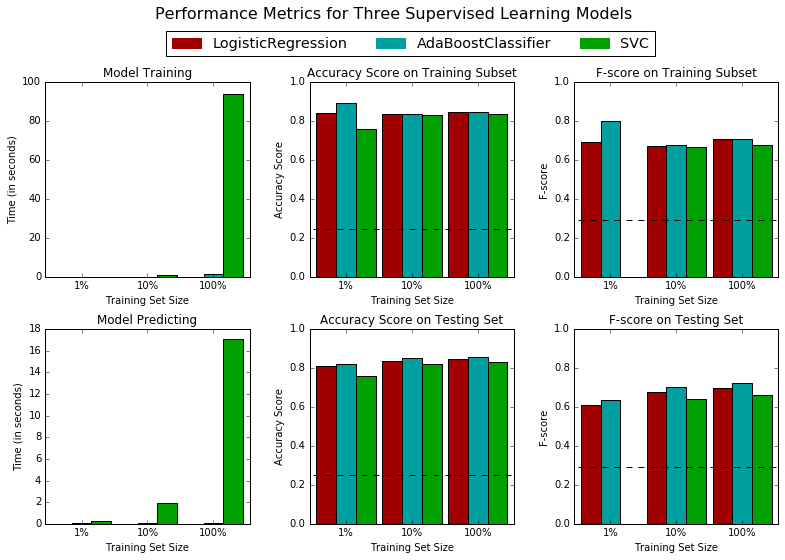

In [46]:
# TODO: Import the three supervised learning models from sklearn
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier
from sklearn.linear_model import LogisticRegression

# TODO: Initialize the three models
clf_A = SVC()
clf_B = AdaBoostClassifier()
clf_C = LogisticRegression()

# TODO: Calculate the number of samples for 1%, 10%, and 100% of the training data
training_size = X_train.shape[0]
samples_1 = int(training_size*0.01)
samples_10 = int(training_size*0.10)
samples_100 = int(training_size*1.00)

# Collect results on the learners
results = {}
for clf in [clf_A, clf_B, clf_C]:
    clf_name = clf.__class__.__name__
    results[clf_name] = {}
    for i, samples in enumerate([samples_1, samples_10, samples_100]):
        results[clf_name][i] = \
        train_predict(clf, samples, X_train, y_train, X_test, y_test)

# Run metrics visualization for the three supervised learning models chosen
vs.evaluate(results, accuracy, fscore)

Note: the f-score for SVC returns 0 for the 1% sample because the size is too small. See more [here](https://stackoverflow.com/questions/34757653/why-does-scikitlearn-says-f1-score-is-ill-defined-with-fn-bigger-than-0/34758800#34758800).

----
## Improving Results
In this final section, you will choose from the three supervised learning models the *best* model to use on the student data. You will then perform a grid search optimization for the model over the entire training set (`X_train` and `y_train`) by tuning at least one parameter to improve upon the untuned model's F-score. 

### Question 3 - Choosing the Best Model
*Based on the evaluation you performed earlier, in one to two paragraphs, explain to *CharityML* which of the three models you believe to be most appropriate for the task of identifying individuals that make more than \$50,000.*  
**Hint:** Your answer should include discussion of the metrics, prediction/training time, and the algorithm's suitability for the data.

**Answer: **

I'd argue that AdaBoost is the most suitable algorithm for classification of adult's income level. While its performance is very similar to Logistic Regression on the training set, AdaBoost has a slight advantage over Logistic Regression on the test dataset; this hints that AdaBoost is more accurately forming a generalized model. 

Simply, the support vector classifier is entirely too slow to use, especially since it's performance is lagging behind AdaBoost. 

### Question 4 - Describing the Model in Layman's Terms
*In one to two paragraphs, explain to *CharityML*, in layman's terms, how the final model chosen is supposed to work. Be sure that you are describing the major qualities of the model, such as how the model is trained and how the model makes a prediction. Avoid using advanced mathematical or technical jargon, such as describing equations or discussing the algorithm implementation.*

**Answer: ** 

The general concept behind AdaBoost is the we can build a robust prediction model by combining a large number of simple insights. Each insight on its own wouldn't be helpful enough to build a useful model, but the additive effect of every insight yields a powerful predictor. These simple insights are provided by weak learners, which are models that can do only slightly better than a random guess. AdaBoost trains these weak learners sequentially, each time fitting a simple model on a sample of the training data. After training a weak learner, the algorithm evaluates how well it performed and places more emphasis in the following round on the observations in which the current model performs poorly on. After a number of iterations, reaching sufficently low error, the models are combined for form a robust predictor. 

Decision trees are a common weak learner; this model makes predictions on the data by answering successive questions about the features, each question depending on the answer to the previous question. I've written more about decision trees [here](http://www.jeremyjordan.me/decision-trees-for-classification/) and ensemble learning methods [here](http://www.jeremyjordan.me/ensemble-learning/).

### Implementation: Model Tuning
Fine tune the chosen model. Use grid search (`GridSearchCV`) with at least one important parameter tuned with at least 3 different values. You will need to use the entire training set for this. In the code cell below, you will need to implement the following:
- Import [`sklearn.grid_search.GridSearchCV`](http://scikit-learn.org/0.17/modules/generated/sklearn.grid_search.GridSearchCV.html) and [`sklearn.metrics.make_scorer`](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.make_scorer.html).
- Initialize the classifier you've chosen and store it in `clf`.
 - Set a `random_state` if one is available to the same state you set before.
- Create a dictionary of parameters you wish to tune for the chosen model.
 - Example: `parameters = {'parameter' : [list of values]}`.
 - **Note:** Avoid tuning the `max_features` parameter of your learner if that parameter is available!
- Use `make_scorer` to create an `fbeta_score` scoring object (with $\beta = 0.5$).
- Perform grid search on the classifier `clf` using the `'scorer'`, and store it in `grid_obj`.
- Fit the grid search object to the training data (`X_train`, `y_train`), and store it in `grid_fit`.

**Note:** Depending on the algorithm chosen and the parameter list, the following implementation may take some time to run!

In [47]:
# TODO: Import 'GridSearchCV', 'make_scorer', and any other necessary libraries
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import fbeta_score, make_scorer


# TODO: Initialize the classifier
clf = AdaBoostClassifier(random_state=0)

# Initialize weak learners
from sklearn.tree import DecisionTreeClassifier
# from sklearn.neighbors import KNeighborsClassifier

dt1 = DecisionTreeClassifier(max_depth=1) 
dt2 = DecisionTreeClassifier(max_depth=5) 
# knn = KNeighborsClassifier()

# TODO: Create the parameters list you wish to tune
parameters = {'base_estimator': [dt1, dt2],
              'n_estimators': [10, 50, 100, 200],
              'learning_rate': [0.1, 0.5, 1, 5]}

# TODO: Make an fbeta_score scoring object
scorer = fbeta_scorer = make_scorer(fbeta_score, beta=0.5)

# TODO: Perform grid search on the classifier using 'scorer' as the scoring method
grid_obj = GridSearchCV(clf, parameters, scoring = scorer)

# TODO: Fit the grid search object to the training data and find the optimal parameters
grid_fit = grid_obj.fit(X_train, y_train)

# Get the estimator
best_clf = grid_fit.best_estimator_

# Make predictions using the unoptimized and model
predictions = (clf.fit(X_train, y_train)).predict(X_test)
best_predictions = best_clf.predict(X_test)

# Report the before-and-afterscores
print "Unoptimized model\n------"
print "Accuracy score on testing data: {:.4f}".format(accuracy_score(y_test, predictions))
print "F-score on testing data: {:.4f}".format(fbeta_score(y_test, predictions, beta = 0.5))
print "\nOptimized Model\n------"
print "Final accuracy score on the testing data: {:.4f}".format(accuracy_score(y_test, best_predictions))
print "Final F-score on the testing data: {:.4f}".format(fbeta_score(y_test, best_predictions, beta = 0.5))

Unoptimized model
------
Accuracy score on testing data: 0.8576
F-score on testing data: 0.7246

Optimized Model
------
Final accuracy score on the testing data: 0.8677
Final F-score on the testing data: 0.7508


In [81]:
best_clf

AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=5,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best'),
          learning_rate=0.1, n_estimators=50, random_state=None)

### Question 5 - Final Model Evaluation
_What is your optimized model's accuracy and F-score on the testing data? Are these scores better or worse than the unoptimized model? How do the results from your optimized model compare to the naive predictor benchmarks you found earlier in **Question 1**?_  
**Note:** Fill in the table below with your results, and then provide discussion in the **Answer** box.

#### Results:


|     Metric     | Benchmark Predictor | Unoptimized Model | Optimized Model |
| :------------: | :-----------------: | :---------------: | :-------------: | 
| Accuracy Score |     0.2489          |     0.8576        |     0.8663      |
| F-score        |     0.2929          |     0.7246        |     0.7481      |
 

**Answer: **

Both the unoptimized and optimized model vastly outpeform a naive predictor. However, I would argue that the naive predictor should actually predict that every adult makes less than \$50,000 seeing as that was the mode of the original dataset. If this is the case, our benchmark predictor becomes:

Accuracy score: 0.7511
F-score: 0.0000

The f-score calculation has precision in the numerator, which in this event is equal to zero because we never predict the positive class.

When comparing the accuracy of the adjusted benchmark to that of generated models, the benchmark performance is still worse but to a much less significant degree. It would be interesting to evaluate our model on a dataset which has a uniform distribution of classes and compare peformance between the benchmark (which should now be 50\%) and our model. 

----
## Feature Importance

An important task when performing supervised learning on a dataset like the census data we study here is determining which features provide the most predictive power. By focusing on the relationship between only a few crucial features and the target label we simplify our understanding of the phenomenon, which is most always a useful thing to do. In the case of this project, that means we wish to identify a small number of features that most strongly predict whether an individual makes at most or more than \$50,000.

Choose a scikit-learn classifier (e.g., adaboost, random forests) that has a `feature_importance_` attribute, which is a function that ranks the importance of features according to the chosen classifier.  In the next python cell fit this classifier to training set and use this attribute to determine the top 5 most important features for the census dataset.

### Question 6 - Feature Relevance Observation
When **Exploring the Data**, it was shown there are thirteen available features for each individual on record in the census data.  
_Of these thirteen records, which five features do you believe to be most important for prediction, and in what order would you rank them and why?_

**Answer:**

As a reminder, the columns in the orinal dataset are:

u'age', u'workclass', u'education_level', u'education-num', u'marital-status', u'occupation', u'relationship', u'race', u'sex', u'capital-gain', u'capital-loss', u'hours-per-week', u'native-country', u'income'
       
Ranked feature importance:

1. Education level. 
    - High paying jobs typically require advanced degrees. 
2. Capital gain. 
    - If somebody is making capital gains (likely in the stock market), this could be a clue that they are financially savvy. 
3. Age.
    - Income tends to rise with age and experience. 
4. Hours per week. 
    - Some high-earners (investment bankers, consultants) work insane weekly hours. Some of the poor class might also work very high hours (fieldsmen in agriculture, construction workers). The middle class is likely to stick to 40 hrs/wk. This trend might be parabolic. 
5. Occupation. 
    - Average earnings can typically be estimated according to the occupation. 



### Implementation - Extracting Feature Importance
Choose a `scikit-learn` supervised learning algorithm that has a `feature_importance_` attribute availble for it. This attribute is a function that ranks the importance of each feature when making predictions based on the chosen algorithm.

In the code cell below, you will need to implement the following:
 - Import a supervised learning model from sklearn if it is different from the three used earlier.
 - Train the supervised model on the entire training set.
 - Extract the feature importances using `'.feature_importances_'`.

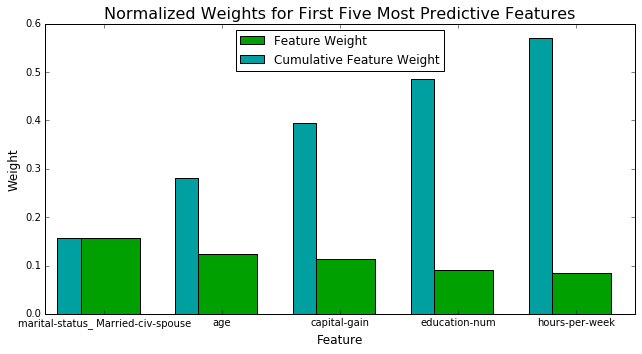

In [82]:
# TODO: Import a supervised learning model that has 'feature_importances_'

# TODO: Train the supervised model on the training set 
model = best_clf

# TODO: Extract the feature importances
importances = model.feature_importances_

# Plot
vs.feature_plot(importances, X_train, y_train)

### Question 7 - Extracting Feature Importance

Observe the visualization created above which displays the five most relevant features for predicting if an individual makes at most or above \$50,000.  
_How do these five features compare to the five features you discussed in **Question 6**? If you were close to the same answer, how does this visualization confirm your thoughts? If you were not close, why do you think these features are more relevant?_

**Answer:**

I was surprised that marital status had such a significant impact on individual income. I would have expected a positive correlation between martial status and household income, but much less of an impact on individual income. If education-num represents the highest grade level of completed education, I could see how this is more important than the categorical education level. However, I could not find a comprehensive description of the feature-set so I did not know if this was the case. 

### Feature Selection
How does a model perform if we only use a subset of all the available features in the data? With less features required to train, the expectation is that training and prediction time is much lower — at the cost of performance metrics. From the visualization above, we see that the top five most important features contribute more than half of the importance of **all** features present in the data. This hints that we can attempt to *reduce the feature space* and simplify the information required for the model to learn. The code cell below will use the same optimized model you found earlier, and train it on the same training set *with only the top five important features*. 

In [83]:
# Import functionality for cloning a model
from sklearn.base import clone

# Reduce the feature space
X_train_reduced = X_train[X_train.columns.values[(np.argsort(importances)[::-1])[:5]]]
X_test_reduced = X_test[X_test.columns.values[(np.argsort(importances)[::-1])[:5]]]

# Train on the "best" model found from grid search earlier
clf = (clone(best_clf)).fit(X_train_reduced, y_train)

# Make new predictions
reduced_predictions = clf.predict(X_test_reduced)

# Report scores from the final model using both versions of data
print "Final Model trained on full data\n------"
print "Accuracy on testing data: {:.4f}".format(accuracy_score(y_test, best_predictions))
print "F-score on testing data: {:.4f}".format(fbeta_score(y_test, best_predictions, beta = 0.5))
print "\nFinal Model trained on reduced data\n------"
print "Accuracy on testing data: {:.4f}".format(accuracy_score(y_test, reduced_predictions))
print "F-score on testing data: {:.4f}".format(fbeta_score(y_test, reduced_predictions, beta = 0.5))

Final Model trained on full data
------
Accuracy on testing data: 0.8663
F-score on testing data: 0.7481

Final Model trained on reduced data
------
Accuracy on testing data: 0.8485
F-score on testing data: 0.7013


### Question 8 - Effects of Feature Selection
*How does the final model's F-score and accuracy score on the reduced data using only five features compare to those same scores when all features are used?*  
*If training time was a factor, would you consider using the reduced data as your training set?*

**Answer:**

The f-score drops more significantly than the accuracy when training a model on a reduced set of features, but they still peform decently well. Except for the case of exceptionally short training times, I'd probably still use the full feature set as it trains decently fast already. 

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  
**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.